# ChebNet

In [1]:
import src.ChebNet as ChebNet
import src.CORA as CORA
import src.utils as utils

import dgl
import torch
import time

In [2]:
# Reload when files are changed
import importlib
importlib.reload(ChebNet)
importlib.reload(CORA)
importlib.reload(utils)

<module 'src.utils' from '/home/infres/avalenca-22/CayleyNets/src/utils.py'>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Checking torch and device

# Torch version
print(torch.__version__)

2.1.1+cu121


In [5]:
# Import dataset
cora = CORA.CORA()

Parsing files...
Done.


In [6]:
# Use GPU if available (DGL doesn't seem to support MPS)
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [7]:
train_mask, test_mask, val_mask = utils.split_train_test_val(cora.n, 500, 500) # extended split of the CORA dataset

In [8]:
# Hyperparameters (Section 4.5)
in_feats = cora.n_features
n_classes = cora.n_classes
n_hidden = 16
n_layers = 1 # number of hidden+output layers
k = 10 # Chebyshev polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper, only that it is 2r, r being the degree of the Cayley polynomial

In [9]:
# Graph as an object
graph = dgl.from_scipy(cora.adjacency)

# Features and labels as tensors
features = torch.Tensor(cora.features).to(device)
labels = torch.Tensor(cora.labels).long().to(device)

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

In [10]:
# Define model
p = 0.5 # dropout probability
model = ChebNet.ChebNet(in_feats, n_classes, n_hidden, n_layers, k, p).to(device)
model

ChebNet(
  (layers): ModuleList(
    (0): ChebConv(
      (linear): Linear(in_features=14330, out_features=16, bias=False)
    )
    (1): ChebConv(
      (linear): Linear(in_features=160, out_features=7, bias=False)
    )
  )
)

In [11]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')

Number of parameters: 230400
Number of parameters: 229280
Number of parameters: 1120


In [12]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [13]:
# Train the model
batch_size = 32
epochs = 200

# save loss values for plotting
loss_values = []
val_score = []
train_score = []

verbose = True
for e in range(epochs):
    start = time.time()

    # Compute output
    output = model(graph, features)

    # Compute loss
    logp = F.log_softmax(output, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    loss_values.append(loss.item())

    # Perform backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    score = utils.eval_dgl_model(model, graph, features, labels, train_mask)
    train_score.append(score)

    score = utils.eval_dgl_model(model, graph, features, labels, val_mask)
    val_score.append(score)

    end = time.time()
    if verbose and e % 10 == 0:
        print("Epoch {:02d} | Loss {:.3f} | Accuracy (validation) {:.3f} | Elapsed time: {:.2f}s".format(e, loss.item(), score, end - start))

Epoch 00 | Loss 1.947 | Accuracy (validation) 0.302 | Elapsed time: 0.38s
Epoch 10 | Loss 1.007 | Accuracy (validation) 0.676 | Elapsed time: 0.34s
Epoch 20 | Loss 0.548 | Accuracy (validation) 0.756 | Elapsed time: 0.26s
Epoch 30 | Loss 0.450 | Accuracy (validation) 0.758 | Elapsed time: 0.26s
Epoch 40 | Loss 0.435 | Accuracy (validation) 0.752 | Elapsed time: 0.23s
Epoch 50 | Loss 0.435 | Accuracy (validation) 0.750 | Elapsed time: 0.24s
Epoch 60 | Loss 0.439 | Accuracy (validation) 0.756 | Elapsed time: 0.22s
Epoch 70 | Loss 0.438 | Accuracy (validation) 0.750 | Elapsed time: 0.24s
Epoch 80 | Loss 0.434 | Accuracy (validation) 0.748 | Elapsed time: 0.26s
Epoch 90 | Loss 0.433 | Accuracy (validation) 0.754 | Elapsed time: 0.24s
Epoch 100 | Loss 0.433 | Accuracy (validation) 0.748 | Elapsed time: 0.26s
Epoch 110 | Loss 0.432 | Accuracy (validation) 0.748 | Elapsed time: 0.26s
Epoch 120 | Loss 0.431 | Accuracy (validation) 0.748 | Elapsed time: 0.24s
Epoch 130 | Loss 0.433 | Accuracy (

In [14]:
test_score = utils.eval_dgl_model(model, graph, features, labels, test_mask)
print("Test accuracy {:.3f}".format(test_score))

Test accuracy 0.744


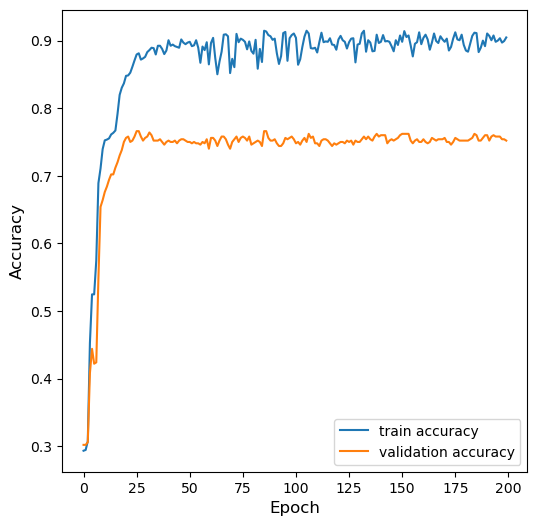

In [15]:
utils.plot_accuracy(train_score, val_score)

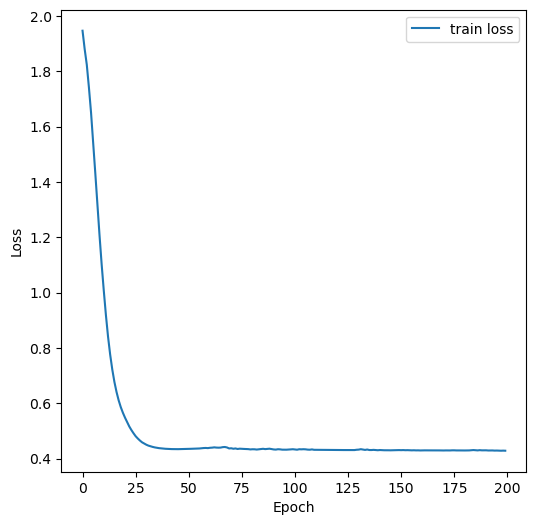

In [16]:
utils.plot_loss(loss_values)